In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import preprocessing
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [3]:
def create_our_columns(dataframe):
    grouped = dataframe.groupby('ident')
    masa_total = grouped.sum()['emepla(i)/emet']
    eficiencia = masa_total/(grouped['emed'].first())
    n_planetas = grouped.size()
    print(masa_total, eficiencia, n_planetas)
    
    new = dataframe.assign(nplanets=n_planetas)
    new = new.assign(tmass=masa_total)
    new = new.assign(eff=eficiencia)
    
    new = new.fillna(value=0)
    return new

def scalate(splitted_data):
    X_train, X_test, Y_train, Y_test = splitted_data
    if len(Y_train.shape) == 1:
        Y_train = Y_train.values.reshape((-1, 1))
        Y_test = Y_test.values.reshape((-1, 1))
        
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_ = scaler.transform(X_train)
    X_test_ = scaler.transform(X_test)
    
    scaler = preprocessing.StandardScaler().fit(Y_train)
    Y_train_ = scaler.transform(Y_train)
    Y_test_ = scaler.transform(Y_test)
    
    return X_train_, X_test_, Y_train_, Y_test_

In [4]:
def lasso_test(data, n_keys, lambdas):
    N = len(lambdas)
    
    X_train, X_test, Y_train, Y_test = data
    
    coefs_norm = np.zeros((N, n_keys + 1))
    scores_norm = np.zeros(N)

    for i in range(N):
        clf = Lasso(alpha = lambdas[i])
        clf.fit(X_train, Y_train)
        coefs_norm[i, 0] = clf.intercept_
        coefs_norm[i, 1:] = clf.coef_
        scores_norm[i] = clf.score(X_test, Y_test)
        
    return coefs_norm, scores_norm
    
def multiple_lasso_testing(dataframe, wanted_index = 0, number_of_test = 1):
    grouped = dataframe.groupby('ident')
    data = grouped.mean()
    keys = list(data.keys())
    wanted = ['nplanets', 'tmass', 'eff']
    to_remove = ['a(i)', 'emegas(i)', 'emepla(i)/emet'] + wanted

    for key in to_remove:
        keys.remove(key)
        
    X_data = data[keys]
    Y_data = data[wanted[wanted_index]]
    n_keys = len(keys)
    n_lambdas = 100
    lambdas = np.logspace(-3, -1, n_lambdas)
    set_coefs = np.zeros((number_of_test, n_lambdas, n_keys + 1))
    set_scores = np.zeros((number_of_test, n_lambdas))
    for i in range(number_of_test):
        splitted = train_test_split(X_data, Y_data)
        coefs_norm, scores_norm = lasso_test(scalate(splitted), n_keys, lambdas)
        set_coefs[i] = coefs_norm
        set_scores[i] = scores_norm
        
    return keys, lambdas, set_coefs, set_scores

def plot(resulting_data):
    keys, lambdas, coeffs, scores = resulting_data
    mean = coeffs.mean(axis=0)
    std = coeffs.std(axis=0)
    fig, ax = plt.subplots()
    for i in range(std.shape[1]-1):
        if i < 10:
            line = '-'
        else:
            line = '--'
        keys[i]
        ax.loglog(lambdas, abs(mean[:, i+1]), line,\
                     label = r"$\beta_{%d}$ '%s'"%(i+1, keys[i]))
    ax.set_ylabel('Coeficientes')
    ax.set_xlabel(r'$\lambda$ value')
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    return fig, ax

In [5]:
low = pd.read_csv('lowp_finalresults.csv')
high = pd.read_csv('highp_finalresults.csv')

In [6]:
low_complete = create_our_columns(low)
high_complete = create_our_columns(high)

ident
0         6.705383
1         2.725320
2        10.749995
3         6.397114
4         2.953130
5         4.223813
6         2.265727
7         3.738926
8         3.827600
9        12.153030
10        6.292921
11        7.751707
12        0.487479
13       10.258344
14       16.782661
15       19.225524
16        5.978505
17        0.666141
19        2.409805
20        6.391821
21        0.275643
22        2.018205
23        4.233876
24        0.980548
25        6.751100
26      113.001117
27       12.303031
28        4.483195
29        4.445503
31        3.859929
           ...    
2938      2.215946
2939     31.107775
2940      7.276633
2941      9.647982
2942      8.004835
2943     29.213666
2944      4.729692
2946      8.396073
2947      4.834974
2948      4.819962
2949      9.145983
2950      2.144217
2951     15.877198
2952      3.703254
2953      5.701934
2954      2.095954
2955      4.589134
2956      3.226423
2958      3.305239
2959      4.586070
2961      3.177809
2963  

# LASSO studies

### Planets number

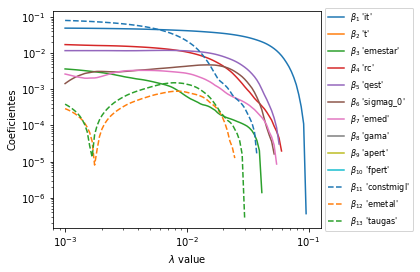

In [6]:
fig, ax = plot(multiple_lasso_testing(low_complete, 0, 100))
fig

### Total mass

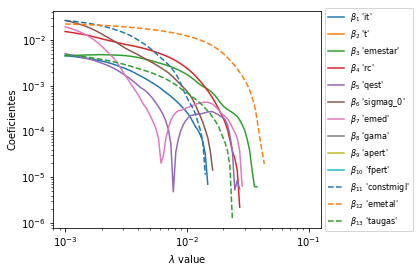

In [7]:
fig, ax = plot(multiple_lasso_testing(low_complete, 1, 100))
fig

### Eficiencia

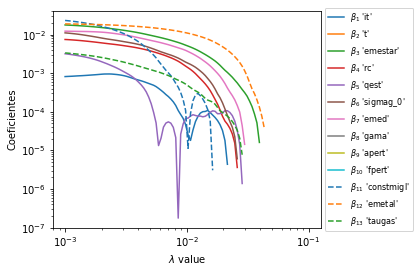

In [8]:
fig, ax = plot(multiple_lasso_testing(low_complete, 2, 100))
fig

In [20]:
wanted_index = 0
low_complete
grouped = low_complete.groupby('ident')
data = grouped.mean()
keys = list(data.keys())
wanted = ['nplanets', 'tmass', 'eff']
to_remove = ['a(i)', 'emegas(i)', 'emepla(i)/emet'] + wanted

for key in to_remove:
    keys.remove(key)
        
X_data = data[keys]
Y_data = data[wanted[wanted_index]]

F, pval = f_classif(X_data, Y_data)

/home/juan/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [7 9] are constant.
  UserWarning)
/home/juan/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [21]:
print(F)
print(pval)

[ 1.87711785  1.53093093  0.97492304  0.97977303  1.15386999  0.69606304
  0.82121426         nan  2.77835613         nan -0.46679086  0.86395015
  1.03698385]
[  5.90511591e-11   1.12860043e-05   5.80761833e-01   5.62803742e-01
   8.26577547e-02   9.99220603e-01   9.59645075e-01              nan
   1.04580715e-28              nan              nan   9.02907656e-01
   3.55717391e-01]


In [24]:
model = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression(normalize=True,n_jobs=-1))])
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
sk.metrics.r2_score(Y_test, y_pred)

-1.9296198621732793e+21